# Back to the Future : Time Travelling through Wikispeedia

## Part 0 : Preprocessing of data

#### Setting the environment 
Please check SETUP.md and pip_requirements.txt before running this notebook.

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import os as os
import sys
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

sys.path.append('../') 
sys.path.append('../data/') 
from src.scripts.loading_data import *
from src.utils.data_utils import *
from src.scripts.plotting import *

Some definitions:
- source article: the initial point of a game
- target article: the final point that players are looking for.
- path: all the articles visited by the player during his/her game, including the source and target articles (if the latter is found)


## Part 1 : Defining the best moment to play Wikispeedia

### 1.0) Introduction
The start point of our journey is situated in the past, in 2007. We investigate possible reasons of failure at the Wikispeedia game on articles from 2007. For this purpose, we use the dataset furnished [1][2].


### 1.1) Exploring categories
The categories of the articles are given in the `categories.tsv` file.

#### 1.1.1) Cleaning the categories

In [2]:
articles2007, links2007 = loading_articles_links('2007')

categories = loading_cleaned_categories()
print(f'Shape of categories df: {categories.shape}, number of unique articles in categories.tsv: {categories.index.unique().shape}, number of articles in articles.tsv: {articles2007.article_2007.unique().shape}')

Shape of categories df: (5204, 3), number of unique articles in categories.tsv: (5204,), number of articles in articles.tsv: (4604,)


Wait a minute... There is more rows in categories than the number of articles. Some articles have more than 1 category! In addition, there are less unique appearance of articles than the total number of articles in `articles.tsv`! We want to fix that for our Sankey diagram. First let's find the 6 articles missing in `categories.tsv`.

In [3]:
articles_not_in_categories = art_not_in_cat(articles2007, categories, 'article_2007')
articles_not_in_categories

array(['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu',
       'Sponsorship_Directdebit', 'Wowpurchase'], dtype=object)

We got them. Let's keep them here for later, it might be useful. Now let's deal with articles having several categories. First, let's find them.

In [4]:
categories.article.value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

4000 articles have only 1 category, 590 have 2 categories and 8 of them have 3 categories.

In [5]:
categories_duplicated = categories.loc[categories.index.duplicated(keep=False)]
categories_duplicated

,article,category,main_category


In [6]:
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category
177,Al_Jazeera,"[Citizenship, Media]",Citizenship
178,Al_Jazeera,"[Citizenship, Politics_and_government]",Citizenship
205,Alfred_the_Great,"[People, Military_People]",People
206,Alfred_the_Great,"[People, Monarchs_of_Great_Britain]",People
297,Animation,"[Everyday_life, Computer_and_Video_games]",Everyday_life
...,...,...,...
5046,Whipworm,"[Science, Biology, Organisms]",Science
5051,White_cliffs_of_Dover,"[Geography, Geography_of_Great_Britain]",Geography
5052,White_cliffs_of_Dover,"[Geography, Geology_and_geophysics]",Geography
5068,William_Ewart_Gladstone,"[People, Historical_figures]",People


We notice that some articles have the same main category but the subcategories are different. Let's focus on the main category and get rid off the other subcategories. We keep delete one the duplicated main category for every concerned article. 

In [7]:
categories = categories.drop(index=categories.loc[categories[['article', 'main_category']].duplicated()].index)
categories

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
4,%C3%89douard_Manet,"[People, Artists]",People
...,...,...,...
5199,Zirconium,"[Science, Chemistry, Chemical_elements]",Science
5200,Zoroaster,"[People, Religious_figures_and_leaders]",People
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography
5202,Zuid-Gelders,"[Language_and_literature, Languages]",Language_and_literature


In [8]:
# let's check if this problem is solved, i.e. this command return an empty df
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category


In [9]:
# update the df containing only duplicated articles. We have deleted 90 useless rows. 
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


It looks better, but we still have 1013 rows to sort out. From now on, we will do purely arbitrary choices to keep only one main category.
You can find the logical reasoning and examples of paths concerned in `categories_partial_ordering.md`. Using this partial ordering, we can kick out the duplicated articles we do not want.

In [10]:

relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'),
 ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), 
 ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), 
 ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('Design_and_Technology', 'History'), 
 ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('Geography', 'History'),
 ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'),
 ('Science', 'Citizenship'), ('IT', 'Business_Studies'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'),
 ('Everyday_life', 'Citizenship'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('IT', 'Science'),
 ('Geography', 'Everyday_life'), ('Science', 'Geography'), ('Business_Studies', 'History'), ('History', 'Citizenship'),
 ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'),
 ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'),
 ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), 
 ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

categories, categories_duplicated = delete_duplicates_cat(categories, relationships)

print(f'Number of unique article names in categories: {categories.article.unique().size}, number of rows: {categories.article.size}.')

categories = categories.set_index('article') # easier for the following

display(categories_duplicated) # is empty, as expected

Number of unique article names in categories: 4598, number of rows: 4598.


,article,category,main_category


In [11]:
plot_cat_pie_chart(categories)

#### 1.1.2) Links and categories

Now each article has only one category assigned. We can thus work with the categories. First, let's analyse where links present in an article of a given category send the player: in the same category, or in another one?


In [12]:
# have to check that the articles present in the links.tsv are in categories.tsv

# retrieve all the article names present in links.tsv
articles_names_from_links = list(links2007.linkSource.unique()) + list(links2007.linkTarget.unique())

# keep 1 occurence per name only
articles_names_from_links = pd.DataFrame.from_dict({'article': list(set(articles_names_from_links))})

# find the articles that are not in categories.tsv
articles_to_drop = art_not_in_cat(articles_names_from_links, categories, 'article', index=True)
print(f'{len(articles_to_drop)} articles have to be dropped: {articles_to_drop}')

# We drop them because we can not associate a category to them:
links2007 = links2007.loc[~links2007.linkSource.isin(articles_to_drop) & ~links2007.linkTarget.isin(articles_to_drop)]

# We add columns containing the categories of the source and target articles
links2007['catSource'] = links2007['linkSource'].map(lambda x: categories.main_category.loc[x])
links2007['catTarget'] = links2007['linkTarget'].map(lambda x: categories.main_category.loc[x])

links2007

4 articles have to be dropped: ['Sponsorship_Directdebit' 'Directdebit' 'Pikachu' 'Friend_Directdebit']


,linkSource,linkTarget,catSource,catTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,History,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,History,People
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,History,History
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,History,History
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,History,Countries
...,...,...,...,...
119877,Zulu,South_Africa,Geography,Countries
119878,Zulu,Swaziland,Geography,Countries
119879,Zulu,United_Kingdom,Geography,Countries
119880,Zulu,Zambia,Geography,Countries


In [13]:
distrib_links, num_links = get_sankey_data(links2007, categories, 'links')


cats = sorted(categories.main_category.unique())
plot_heatmap(distrib_links.reshape(15, 15), cats, num_links, 'links', gamma=0.45)

#### 1.1.3) Category of the source and target articles
Let's analyse the category of the source and target articles between the finished and unfinished paths to determine if it has an influence on the game outcomes.  

In [14]:
path_finished, path_unfinished = loading_paths()

# let's check again that all the article names of interest are present in categories.tsv
articles_not_in_categories = list(articles_not_in_categories) + list(art_not_in_cat(path_finished, categories, 'start', True))

articles_not_in_categories += list(art_not_in_cat(path_finished, categories, 'end', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'start', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'target', True))

articles_not_in_categories = list(set(articles_not_in_categories))
print(f'{len(articles_not_in_categories)} articles do not appear in categories.tsv: {np.array(articles_not_in_categories)}')

# let's remove these paths and add new columns with categories and path length
path_finished, path_unfinished = cleaned_paths(path_finished, path_unfinished, categories, articles_not_in_categories)

31 articles do not appear in categories.tsv: ['_Zebra' 'Netbook' 'Charlottes_web' 'Kashmir' 'Sportacus' 'C++'
 'Western_Australia' 'English' 'Fats' 'Sponsorship_Directdebit'
 'Christmas' 'Donation' 'Macedonia' 'Mustard' 'Adolph_Hitler' 'Usa'
 'The_Rock' 'Wowpurchase' 'Rat' 'Black_ops_2' 'Georgia' 'Great' 'Test'
 'Pikachu' 'Friend_Directdebit' 'Long_peper' 'Podcast' 'Directdebit' 'The'
 'Rss' 'Bogota']
Initial number of rows in path finished: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows in path unfinished: 24875, current number of rows: 19607, percentage of loss: 21.18%


Oof, we are not loosing much data, we can consider this correction as negligble. Let's get the data for the sankey plot. 

In [15]:
path_unfinished

,hashedIpAddress,timestamp,durationInSec,path,target,type,start,end,catSource,catTarget,catEnd,length
2,2b015fb8181c48f2,1297090819,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,Malawi,Alexander_the_Great,Countries,Religion,People,3
4,53a53bc244e08a6a,1297099105,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,Paraguay,Bolivia,Countries,Geography,Countries,2
5,131600803df4895e,1297100557,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout,Agriculture,Yangtze_River,Everyday_life,Geography,Geography,4
6,486bb79910fe9dd2,1297101660,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout,Mind,Asia,Religion,Citizenship,Geography,7
7,6d136e371e42474f,1297102070,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,Australia,Design_and_Technology,Science,Countries,5
...,...,...,...,...,...,...,...,...,...,...,...,...
24869,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,restart,Turks_and_Caicos_Islands,War,Countries,History,History,6
24870,109ed71f571d86e9,1389787605,180,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",Cholera,restart,Franz_Kafka,Ghana,People,Science,Countries,8
24872,2e09a7224600a7cd,1389798400,1900,"[Computer_programming, Linguistics, Culture, P...",The_Beatles,timeout,Computer_programming,Popular_culture,IT,Music,Everyday_life,5
24873,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",Alan_Turing,timeout,Jamaica,Battle_of_Midway,Countries,People,History,4


In [16]:
distrib_f, tot_links_f = get_sankey_data(path_finished, categories, 'f')
distrib_unf, tot_links_unf = get_sankey_data(path_unfinished, categories, 'unf')
distrib_unf_start2end, distrib_unf_end2target, tot_links_start2end, tot_links_end2target = get_multistep_sankey_data(path_unfinished, categories)

global_min = min(np.min(distrib_links), np.min(distrib_f), np.min(distrib_unf), np.min(distrib_unf_start2end)) * 100
global_max = max(np.max(distrib_links), np.max(distrib_f), np.max(distrib_unf), np.max(distrib_unf_start2end)) * 100


all_to_cat_f, cat_to_all_f = plot_heatmap(distrib_f.reshape(15, 15), cats, tot_links_f, 'f', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
all_to_cat_unf, cat_to_all_unf = plot_heatmap(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
plot_heatmap(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45)
plot_heatmap(distrib_unf_start2end.reshape(15, 15), cats, tot_links_unf, 'unf_start', vmin=global_min, vmax=global_max, gamma=0.45)
plot_heatmap(distrib_unf_end2target.reshape(15, 15), cats, tot_links_unf, 'unf_target', vmin=global_min, vmax=global_max, gamma=0.45)

In [17]:
print(all_to_cat_f)
print(all_to_cat_unf)

{'Art': 0.6380612304630335, 'Business_Studies': 1.406856719155496, 'Citizenship': 3.4576284415305665, 'Countries': 8.103572752639078, 'Design_and_Technology': 4.958145524790728, 'Everyday_life': 6.51524907803079, 'Geography': 16.950574645358934, 'History': 9.586528517629613, 'IT': 2.620538937345119, 'Language_and_literature': 2.499560967043259, 'Mathematics': 1.0536790961774865, 'Music': 1.836133387968546, 'People': 9.668481336221195, 'Religion': 3.4673847294581357, 'Science': 27.23760463618802}
{'Art': 0.6681287295353701, 'Business_Studies': 1.820778293466619, 'Citizenship': 4.069975008925383, 'Countries': 2.065588820319274, 'Design_and_Technology': 8.083847605447033, 'Everyday_life': 10.766562962207374, 'Geography': 10.567654409139593, 'History': 9.603712959657265, 'IT': 2.5603100933340133, 'Language_and_literature': 3.7996633855255775, 'Mathematics': 0.7803335543428367, 'Music': 2.443005049217116, 'People': 8.991686642525629, 'Religion': 2.233896057530474, 'Science': 31.544856428826

In [18]:
print(cat_to_all_f)
print(cat_to_all_unf)

{'Art': 0.7766005190345178, 'Business_Studies': 1.633202599075104, 'Citizenship': 3.547386290464204, 'Countries': 5.633280649378525, 'Design_and_Technology': 4.854728872758493, 'Everyday_life': 9.522137017307655, 'Geography': 14.556381587933423, 'History': 7.746492614490038, 'IT': 2.3434603602021506, 'Language_and_literature': 4.915217857909423, 'Mathematics': 1.160998263380749, 'Music': 1.806864524185838, 'People': 9.321157485999727, 'Religion': 2.866397393119865, 'Science': 29.315693964760285}
{'Art': 0.8211353088182791, 'Business_Studies': 1.5147651349008004, 'Citizenship': 3.2896414545825468, 'Countries': 5.1665221604528995, 'Design_and_Technology': 7.99714387718672, 'Everyday_life': 8.721375019125823, 'Geography': 13.270770643137656, 'History': 7.2066098842250215, 'IT': 2.17269342581731, 'Language_and_literature': 6.803692558780027, 'Mathematics': 1.2444535115009945, 'Music': 1.6575712755648493, 'People': 8.323557912990259, 'Religion': 2.805120620186668, 'Science': 29.004947212730

We can see differences between the proportions. But are they significiant?

In [19]:
# NEXTSTEP:: check one more time that we use the right statistical test

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
# from scipy.stats import bartlett
# predictor: categorical, 2 of them: start and end
# outcome: continuous (in N)
# ==> anova
# Null hypothesis: the distributions are different.
# Alternative hypothesis: the distributions are identic.

f_oneway(distrib_f, distrib_unf)
# p-value = 1 >>>> 0.05 ==> can't say it's different 


print(chi2_contingency_test(distrib_f*tot_links_f, distrib_unf*tot_links_unf))
print(chi2_contingency_test(distrib_f*tot_links_f, distrib_unf_start2end*tot_links_start2end))
print(chi2_contingency_test(distrib_f*tot_links_f, distrib_unf_end2target*tot_links_end2target))
print(chi2_contingency_test(distrib_unf_start2end*tot_links_start2end, distrib_unf_end2target*tot_links_end2target))
print(chi2_contingency_test(np.array(list(all_to_cat_f.values()))*tot_links_f, np.array(list(all_to_cat_unf.values()))*tot_links_unf))
print(chi2_contingency_test(np.array(list(cat_to_all_f.values()))*tot_links_f, np.array(list(cat_to_all_unf.values()))*tot_links_unf))

(0.0, 2953.306794291134)
(0.0, 4383.703330901606)
(0.0, 10132.941451042401)
(0.0, 8204.090707335448)
(0.0, 207557.75636787878)
(0.0, 39997.7909730497)


We can not say that the distribution of categories are different.

Some paths are really short: it seems like the player didn't even try to play... Let's remove the paths with a length smaller or equal to 3 (i.e. the player clicked on 2 links at most). Does it change something? 

In [20]:
path_unfinished_trunc = path_unfinished.copy(deep=True)
path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=4)]
path_unfinished_trunc


,hashedIpAddress,timestamp,durationInSec,path,target,type,start,end,catSource,catTarget,catEnd,length
5,131600803df4895e,1297100557,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout,Agriculture,Yangtze_River,Everyday_life,Geography,Geography,4
6,486bb79910fe9dd2,1297101660,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout,Mind,Asia,Religion,Citizenship,Geography,7
7,6d136e371e42474f,1297102070,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,Australia,Design_and_Technology,Science,Countries,5
9,6d136e371e42474f,1297104110,2006,"[Logic, Computer_science, Science, Physical_sc...",Moon_landing,timeout,Logic,Neil_Armstrong,Religion,Science,People,9
10,430ca00e7f5303b7,1297126187,1976,"[Battle_of_Gettysburg, Washington%2C_D.C., Uni...",Ostrich,timeout,Battle_of_Gettysburg,Animal,History,Science,Science,7
...,...,...,...,...,...,...,...,...,...,...,...,...
24869,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,restart,Turks_and_Caicos_Islands,War,Countries,History,History,6
24870,109ed71f571d86e9,1389787605,180,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",Cholera,restart,Franz_Kafka,Ghana,People,Science,Countries,8
24872,2e09a7224600a7cd,1389798400,1900,"[Computer_programming, Linguistics, Culture, P...",The_Beatles,timeout,Computer_programming,Popular_culture,IT,Music,Everyday_life,5
24873,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",Alan_Turing,timeout,Jamaica,Battle_of_Midway,Countries,People,History,4


We got rid of roughly 10 000 paths! 

In [21]:
distrib_unf_trunc, tot_links_unf_trunc = get_sankey_data(path_unfinished, categories, 'unf')
plot_heatmap(distrib_unf_trunc.reshape(15,15), cats, tot_links_unf, 'unf_target', vmin=global_min, vmax=global_max, gamma=0.45)

In [22]:
plot_heatmap_differences(distrib_f.reshape(15, 15), distrib_unf.reshape(15, 15), cats, tot_links_f)

In [23]:
# NEXTSTEP:: check one more time that we use the right statistical test
# same test
f_oneway(distrib_f, distrib_unf_trunc)

F_onewayResult(statistic=1.1819300616721256e-08, pvalue=0.9999133051341907)

But we can still not say that the distribution is different... what if we take a higher threshold to count an unfinished path as a proper game? 

In [24]:
# NEXTSTEP:: check one more time that we use the right statistical test
for i in range(2, 20):
    path_unfinished_trunc = path_unfinished.copy(deep=True)
    path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=i)]
    
    distrib_unf_trunc, tot_unf_trunc = get_sankey_data(path_unfinished_trunc, categories, 'unf', suffix_fn=str(i))

    stat, pval_anova = f_oneway(distrib_f, distrib_unf_trunc)
    pval, stat_chi2 = chi2_contingency_test(distrib_f*tot_links_f, distrib_unf_trunc*tot_unf_trunc)
    
    print(f'i={i}, number of rows kept:{path_unfinished_trunc.shape[0]}, percentage of rows kept:{100-(path_unfinished.shape[0]-path_unfinished_trunc.shape[0])/path_unfinished.shape[0]*100:.2f}%, pval anova={pval_anova:.3f}, pval ttest={pval:.3f}')

i=2, number of rows kept:19607, percentage of rows kept:100.00%, pval anova=1.000, pval ttest=0.000
i=3, number of rows kept:16390, percentage of rows kept:83.59%, pval anova=1.000, pval ttest=0.000
i=4, number of rows kept:13234, percentage of rows kept:67.50%, pval anova=1.000, pval ttest=0.000
i=5, number of rows kept:10514, percentage of rows kept:53.62%, pval anova=1.000, pval ttest=0.000
i=6, number of rows kept:8060, percentage of rows kept:41.11%, pval anova=1.000, pval ttest=0.000
i=7, number of rows kept:6280, percentage of rows kept:32.03%, pval anova=1.000, pval ttest=0.000
i=8, number of rows kept:4849, percentage of rows kept:24.73%, pval anova=1.000, pval ttest=0.000
i=9, number of rows kept:3893, percentage of rows kept:19.86%, pval anova=1.000, pval ttest=0.000
i=10, number of rows kept:3099, percentage of rows kept:15.81%, pval anova=1.000, pval ttest=0.000
i=11, number of rows kept:2520, percentage of rows kept:12.85%, pval anova=1.000, pval ttest=0.000
i=12, number 

Mmm, the pvalue is below the level of significiance of 0.05 only for paths longer than 15 articles, i.e. when the player clicked on at least 14 links. Considering these long paths only reduces considerably the percentages of data considered, making the sample too small to be significantly relevant. Thus, we can conclude quite safely that the category of the start and target articles is not the main reason behind failure.

# Logistic regression du désespoir

In [25]:
path_finished_super_reduced = path_finished[['start', 'end', 'path']].copy(deep=True).rename(columns={'end':'target'})
path_unfinished_super_reduced = path_unfinished[['start', 'target', 'path']].copy(deep=True)
# path_unfinished_super_reduced = path_unfinished_super_reduced[path_unfinished_super_reduced.path.str.len()>1]

path_finished_super_reduced['finished?'] = 1
path_finished_super_reduced['length'] = path_finished_super_reduced.path.str.len()
path_unfinished_super_reduced['finished?'] = 0
path_unfinished_super_reduced['length'] = path_unfinished_super_reduced.path.str.len()

all_games = pd.concat([path_finished_super_reduced, path_unfinished_super_reduced], axis=0)
all_games['game'] = all_games.apply(lambda x: x.start+', '+x.target, axis=1)

all_games
# all_games = all_games.drop(index=(all_games.game.value_counts()<5))


,start,target,path,finished?,length,game
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",1,9,"14th_century, African_slave_trade"
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",1,5,"14th_century, African_slave_trade"
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",1,8,"14th_century, African_slave_trade"
3,14th_century,Greece,"[14th_century, Renaissance, Ancient_Greece, Gr...",1,4,"14th_century, Greece"
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",1,7,"14th_century, John_F._Kennedy"
...,...,...,...,...,...,...
24869,Turks_and_Caicos_Islands,Iraq_War,"[Turks_and_Caicos_Islands, United_States, Iraq...",0,6,"Turks_and_Caicos_Islands, Iraq_War"
24870,Franz_Kafka,Cholera,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",0,8,"Franz_Kafka, Cholera"
24872,Computer_programming,The_Beatles,"[Computer_programming, Linguistics, Culture, P...",0,5,"Computer_programming, The_Beatles"
24873,Jamaica,Alan_Turing,"[Jamaica, United_Kingdom, World_War_II, Battle...",0,4,"Jamaica, Alan_Turing"


In [26]:

countLinkToTarget = links2007[['linkTarget', 'linkSource']].groupby('linkTarget').count()

article_names_2007 = pd.read_csv('data/2007/articles.tsv', sep='\t', comment='#', names=['article_2007'])
original_links2007 = pd.read_csv('data/2007/links.tsv', sep='\t', comment='#', names=['linkSource', 'linkTarget'])

G_2007 = nx.DiGraph()
G_2007.add_nodes_from(np.unique(article_names_2007))
G_2007.add_edges_from(original_links2007.to_numpy())

def number_links_to_target(game, counts=countLinkToTarget):
    _, end = parse_game_serie(game)
    try:
        n = countLinkToTarget.loc[end].values[0]
    except KeyError as ke:
        n = 0
    return n


def find_cat(art, cat=categories):
    return categories.loc[art].main_category

def parse_game_serie(game):
    split = game.split(', ')
    start = split[0].strip()
    end = split[1].strip()
    return start, end
    
def shortest_path_from_graph(G, game):
    start, end = parse_game_serie(game)
    try:
        x = len(nx.shortest_path(G, source=start, target=end))
    except:
        x = 0
    return x

shortestPath_lst = [shortest_path_from_graph(G_2007, g) for g in all_games.game.unique()]
shortestPath = pd.DataFrame({'shortestPath': shortestPath_lst}, index=all_games.game.unique())


In [27]:



all_games['links_to_target'] = all_games.game.map(number_links_to_target)
all_games = all_games.loc[all_games['links_to_target']!=0]
all_games['log_links_to_target'] = np.log(all_games['links_to_target'])
all_games['shortest_path'] = all_games.game.apply(lambda x: shortestPath.loc[x].values[0])
all_games['catSource'] = all_games.start.apply(lambda x: find_cat(x))
all_games['catTarget'] = all_games.target.apply(lambda x: find_cat(x))

/tmp/ipykernel_49311/4206570497.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_49311/4206570497.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_49311/4206570497.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4

In [172]:
all_games = all_games.loc[all_games.length>1]
all_games

,start,target,path,finished?,length,game,links_to_target,log_links_to_target,shortest_path,catSource,catTarget
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",1,9,"14th_century, African_slave_trade",7,1.945910,4,History,History
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",1,5,"14th_century, African_slave_trade",7,1.945910,4,History,History
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",1,8,"14th_century, African_slave_trade",7,1.945910,4,History,History
3,14th_century,Greece,"[14th_century, Renaissance, Ancient_Greece, Gr...",1,4,"14th_century, Greece",246,5.505332,3,History,Countries
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",1,7,"14th_century, John_F._Kennedy",60,4.094345,4,History,People
...,...,...,...,...,...,...,...,...,...,...,...
24869,Turks_and_Caicos_Islands,Iraq_War,"[Turks_and_Caicos_Islands, United_States, Iraq...",0,6,"Turks_and_Caicos_Islands, Iraq_War",22,3.091042,4,Countries,History
24870,Franz_Kafka,Cholera,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",0,8,"Franz_Kafka, Cholera",38,3.637586,4,People,Science
24872,Computer_programming,The_Beatles,"[Computer_programming, Linguistics, Culture, P...",0,5,"Computer_programming, The_Beatles",61,4.110874,4,IT,Music
24873,Jamaica,Alan_Turing,"[Jamaica, United_Kingdom, World_War_II, Battle...",0,4,"Jamaica, Alan_Turing",11,2.397895,4,Countries,People


In [459]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X_cat = all_games[['shortest_path', 'links_to_target', 'catSource', 'catTarget']]
y_cat = all_games[['finished?']]
X_cat = pd.get_dummies(X_cat, columns=['catSource', 'catTarget'], drop_first=True)

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.4)
X_cat_valid, X_cat_test, y_cat_valid, y_cat_test = train_test_split(X_cat_test, y_cat_test, test_size=0.5)
print(f"No. of training samples: {len(X_cat_train)} No. of validation samples: {len(X_cat_valid)} No. of testing samples: {len(X_cat_test)}")


No. of training samples: 40096 No. of validation samples: 13366 No. of testing samples: 13366


In [460]:
scaler = StandardScaler()

X_cat_train[['links_to_target', 'shortest_path']] = scaler.fit_transform(X_cat_train[['links_to_target', 'shortest_path']])
X_cat_valid[['links_to_target', 'shortest_path']]  = scaler.transform(X_cat_valid[['links_to_target', 'shortest_path']] )
X_cat_test[['links_to_target', 'shortest_path']]  = scaler.transform(X_cat_test[['links_to_target', 'shortest_path']] )

# X_cat_train[[col for col in X_cat_train]] = scaler.fit_transform(X_cat_train[[col for col in X_cat_train]])
# X_cat_valid[[col for col in X_cat_valid]]  = scaler.transform(X_cat_valid[[col for col in X_cat_valid]] )
# X_cat_test[[col for col in X_cat_test]]  = scaler.transform(X_cat_test[[col for col in X_cat_test]])

X_cat_train[[col for col in X_cat_train.columns if col!='links_to_target']] = (X_cat_train[[col for col in X_cat_train.columns if col!='links_to_target']]).astype(int)
X_cat_valid[[col for col in X_cat_valid.columns if col!='links_to_target']]  = (X_cat_valid[[col for col in X_cat_valid.columns if col!='links_to_target']]).astype(int)
X_cat_test[[col for col in X_cat_test.columns if col!='links_to_target']]  = (X_cat_test[[col for col in X_cat_test.columns if col!='links_to_target']]).astype(int)


X_cat_train = sm.add_constant(X_cat_train)
X_cat_valid = sm.add_constant(X_cat_valid)
X_cat_test = sm.add_constant(X_cat_test)

In [461]:
import statsmodels.api as sm

log_reg_cat = sm.Logit(y_cat_train, X_cat_train).fit_regularized() 
print(log_reg_cat.summary()) 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5087682035925676
            Iterations: 153
            Function evaluations: 154
            Gradient evaluations: 153
                           Logit Regression Results                           
Dep. Variable:              finished?   No. Observations:                40096
Model:                          Logit   Df Residuals:                    40065
Method:                           MLE   Df Model:                           30
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.08360
Time:                        19:08:27   Log-Likelihood:                -20400.
converged:                       True   LL-Null:                       -22261.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [462]:
log_reg_cat.pvalues.loc[log_reg_cat.pvalues<0.05]

const                                 2.117112e-11
shortest_path                        1.539120e-173
links_to_target                       1.703571e-83
catSource_Design_and_Technology       1.966855e-03
catTarget_Business_Studies            7.806523e-03
catTarget_Citizenship                 8.590858e-03
catTarget_Countries                   4.255769e-03
catTarget_Design_and_Technology       2.365188e-03
catTarget_Everyday_life               9.277445e-03
catTarget_Geography                   1.549394e-02
catTarget_Language_and_literature     1.535503e-03
catTarget_Mathematics                 2.358983e-04
dtype: float64

In [463]:
def plot_log_reg_coeff(fit):
    fig = go.Figure()

    results = pd.DataFrame(fit.params.sort_values(), columns=['coeff'])
    results['pvalue'] = results.apply(lambda x: fit.pvalues.loc[x.index])
    # print(results)
    fig.add_trace(
        go.Bar(
            y = results.index,
            x = results.coeff,
            orientation = 'h',
            marker_color = ['#ff8b8b' if r>=0.05 else '#8b8bff' for r in results.pvalue.values]
        )
    )
    fig.update_layout(
        width = 800,
        height = 800
    )

    # fig.update_xaxes(type="log")
    
    fig.show()

plot_log_reg_coeff(log_reg_cat)

In [464]:
import sklearn as sk
import sklearn.metrics as metrics


n = 50



def get_metrics(pred_proba, ytrue, n):
    try:
        tmp = [[y[1]>i for y in pred_proba] for i in np.linspace(0, 1, 50)]
    except:
        tmp = [[y>i for y in pred_proba] for i in np.linspace(0, 1, 50)]
    r2 = [metrics.r2_score(ytrue, t) for t in tmp]
    acc = [metrics.accuracy_score(ytrue, t) for t in tmp]
    prec = [metrics.precision_score(ytrue, t) for t in tmp]
    rec = [metrics.recall_score(ytrue, t) for t in tmp]
    f1 = [metrics.f1_score(ytrue, t) for t in tmp]

    return acc, prec, rec, f1, r2



In [465]:
y_cat_pred_p_valid = log_reg_cat.predict(X_cat_valid)

# print(metrics.accuracy_score(y_test, y_test_pred), metrics.precision_score(y_test, y_test_pred), metrics.recall_score(y_test, y_test_pred))


In [466]:

def plot_metrics(acc, prec, rec, f1):
    fig = go.Figure()

    def plot_metric(val, x, name, fig):
        fig.add_trace(go.Scatter(
            x = x,
            y = val,
            name = name,
            mode = 'lines'
        ))

    x = np.linspace(0, 1, len(acc))
    plot_metric(acc, x, 'accuracy', fig)
    plot_metric(rec, x, 'recall', fig)
    plot_metric(prec, x, 'precision', fig)
    plot_metric(f1, x, 'f1-score', fig)


    fig.update_layout(
        barmode='overlay',
        hovermode="x unified",
        width=800, height=500, font_size=18,
        title = dict(text=f"Metrics depending on the threshold value used", x=0.5, xanchor='center'),
        margin=dict(l=20, r=20, t=50, b=20)  
    )

    fig.update_xaxes(
        title_text=f"Threshold")

    fig.update_yaxes(
        title_text=f"Metric"
    )

    plotly_save_to_html(fig, 'metrics_log_reg')

    print(max(acc), x[np.argmax(acc)])


acc, prec, rec, f1, r2 = get_metrics(y_cat_pred_p_valid, y_cat_valid, n)
plot_metrics(acc, rec, prec, f1)
print(r2)

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.7575938949573545 0.5102040816326531
[-0.3347313760734969, -0.3347313760734969, -0.3347313760734969, -0.3347313760734969, -0.3347313760734969, -0.3343331865221624, -0.3339349969708276, -0.3307494805601512, -0.3299531014574819, -0.3295549119061474, -0.32915672235481286, -0.3283603432521436, -0.3283603432521436, -0.32875853280347833, -0.32796215370080906, -0.32796215370080906, -0.3267675850468055, -0.3231838790847943, -0.31561827760943717, -0.312034571647426, -0.3136273298527643, -0.3108400029934224, -0.312034571647426, -0.3060617283774074, -0.30367259106940003, -0.29013414632402434, -0.2973015582480467, -0.29769974779938146, -0.2969033686967122, -0.3092472447880841, -0.35424266408889116, -0.4064054953137204, -0.42591678332911465, -0.4936090070559924, -0.597138290402982, -0.7201788617653659, -0.8416266749224115, -1.0092644760342675, -1.2195085591389234, -1.4158160079468693, -1.679417490930358, -1.8737339919816312, -2.0242496423861005, -2.227326313566734, -2.3866021341005643, -2.52676485

In [467]:
y_cat_pred_p_test = log_reg_cat.predict(X_cat_test).values
y_cat_pred_test = np.where(y_cat_pred_p_test>0.5102040816326531, 1, 0)
print(metrics.accuracy_score(y_cat_test, y_cat_pred_test))

0.7632799640879845


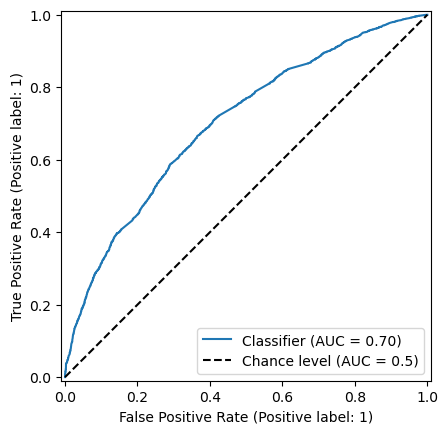

In [468]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(y_cat_test, y_cat_pred_p_test, plot_chance_level=True)

In [469]:

ll_cat_full = log_reg_cat.llf  # Log-likelihood of the fitted model
ll_cat_null = log_reg_cat.llnull  # Log-likelihood of the null model
mcfadden_r2_cat = 1 - (ll_cat_full / ll_cat_null)
mcfadden_r2_cat

0.08360314640461253

In [518]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = all_games[['shortest_path', 'links_to_target']]
y = all_games[['finished?']]
# X = pd.get_dummies(X, columns=['shortest_path'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)
print(f"No. of training samples: {len(X_train)} No. of validation samples: {len(X_valid)} No. of testing samples: {len(X_test)}")


No. of training samples: 40096 No. of validation samples: 13366 No. of testing samples: 13366


In [519]:
scaler = StandardScaler()

X_train[[col for col in X_train.columns]] = scaler.fit_transform(X_train[[col for col in X_train.columns]])
X_valid[[col for col in X_valid.columns]]  = scaler.transform(X_valid[[col for col in X_valid.columns]] )
X_test[[col for col in X_test.columns]]  = scaler.transform(X_test[[col for col in X_test.columns]] )

# X_train[['links_to_target']] = scaler.fit_transform(X_train[['links_to_target']])
# X_valid[['links_to_target']]  = scaler.transform(X_valid[['links_to_target']] )
# X_test[['links_to_target']]  = scaler.transform(X_test[['links_to_target']] )

# X_train[[col for col in X_train.columns if col!='links_to_target']] = (X_train[[col for col in X_train.columns if col!='links_to_target']]).astype(int)
# X_valid[[col for col in X_valid.columns if col!='links_to_target']]  = (X_valid[[col for col in X_valid.columns if col!='links_to_target']]).astype(int)
# X_test[[col for col in X_test.columns if col!='links_to_target']]  = (X_test[[col for col in X_test.columns if col!='links_to_target']]).astype(int)

X_train = sm.add_constant(X_train)
X_valid = sm.add_constant(X_valid)
X_test = sm.add_constant(X_test)

In [520]:
X_train

,const,shortest_path,links_to_target
18685,1.0,-1.378602,-0.272782
15133,1.0,0.039324,-0.069462
26779,1.0,0.039324,-0.487397
47586,1.0,0.039324,-0.442215
40572,1.0,1.457250,-0.024280
...,...,...,...
21716,1.0,0.039324,-0.317964
9007,1.0,-1.378602,-0.521284
20324,1.0,0.039324,-0.363146
13477,1.0,0.039324,-0.363146


In [521]:
import statsmodels.api as sm

log_reg = sm.Logit(y_train, X_train).fit_regularized() 
print(log_reg.summary()) 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5196750622224711
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
                           Logit Regression Results                           
Dep. Variable:              finished?   No. Observations:                40096
Model:                          Logit   Df Residuals:                    40093
Method:                           MLE   Df Model:                            2
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.06666
Time:                        19:09:45   Log-Likelihood:                -20837.
converged:                       True   LL-Null:                       -22325.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [522]:
log_reg.pvalues.loc[log_reg.pvalues<0.05]

const               0.000000e+00
shortest_path      1.846348e-199
links_to_target     2.052341e-97
dtype: float64

In [523]:

plot_log_reg_coeff(log_reg)

In [524]:
y_pred_p_valid = log_reg.predict(X_valid)

# print(metrics.accuracy_score(y_test, y_test_pred), metrics.precision_score(y_test, y_test_pred), metrics.recall_score(y_test, y_test_pred))


In [525]:
acc, prec, rec, f1, r2 = get_metrics(y_pred_p_valid, y_valid, n)
plot_metrics(acc, rec, prec, f1)
print(r2)

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.7599132126290588 0.4693877551020408
[-0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3258605297093542, -0.3250533086867, -0.3250533086867, -0.3250533086867, -0.3250533086867, -0.3250533086867, -0.31819192999414025, -0.31819192999414025, -0.31819192999414025, -0.31819192999414025, -0.31819192999414025, -0.31819192999414025, -0.30325834107503935, -0.2955897413598254, -0.29518613084849843, -0.29518613084849843, -0.29518613084849843, -0.29518613084849843, -0.29518613084849843, -0.29518613084849843, -0.3529024339682665, -0.4320100941883678, -0.4550158933340096, -0.4675278191851482, -0.4727747558323998, -0.4756000294116891, -0.5175755225897021, -0.9316799072112538, -1.2674838526353582, -1.5298306849979397, -1.6872387844154884, -1.81558692701749, -2.0133560775677437, -2.2272696485710792, -2.4282676832119496, -2.589711887742769, -2.732993619263871, -

In [526]:
y_pred_p_test = log_reg.predict(X_test).values
y_pred_test = np.where(y_pred_p_test>0.5918367346938775, 1, 0)
print(metrics.accuracy_score(y_test, y_pred_test))
print(metrics.r2_score(y_test, y_pred_test))


0.7498877749513692
-0.3509348207042764


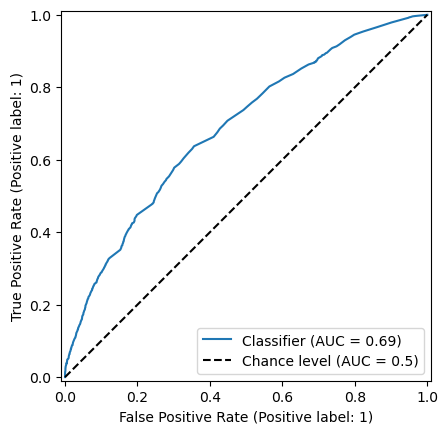

In [527]:


display = RocCurveDisplay.from_predictions(y_test, y_pred_p_test, plot_chance_level=True)

In [528]:

ll_full = log_reg.llf  # Log-likelihood of the fitted model
ll_null = log_reg.llnull  # Log-likelihood of the null model
mcfadden_r2 = 1 - (ll_full / ll_null)
mcfadden_r2

0.06665640786824223

In [529]:
from scipy.stats import ttest_ind

ttest_ind(metrics.f1_score(y_test, y_pred_test), metrics.f1_score(y_cat_test, y_cat_pred_test))
# metrics.f1_score(y_test, y_pred_test), metrics.f1_score(y_cat_test, y_cat_pred_test)

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning:

invalid value encountered in scalar divide



TtestResult(statistic=nan, pvalue=nan, df=0.0)

In [530]:
ll_full

-20836.8912948722

In [531]:
ll_cat_full

-20399.56989124759

In [532]:
chi2_contingency_test(metrics.f1_score(y_test, y_pred_test), metrics.f1_score(y_cat_test, y_cat_pred_test))

(1.0, 0.0)

In [533]:
np.exp(ll_full/ll_cat_full)

2.777184863743242